In [1]:
import os
import re
import time
import torch
import sys
import random
import pickle as pkl
from shutil import copyfile

from pprint import pprint
import torch.optim as optim
from torch.nn import DataParallel
import numpy as np
from torch.autograd import Variable
from PIL import Image
from torchvision import transforms as T
from matplotlib import pyplot as plt
from plot import post_epoch_plot, rgbd_gradients_dataset_first_n
%matplotlib notebook
from models import SpecialFuseNetModel
from data_manager import rgbd_gradients_dataset, rgbd_gradients_dataloader
from train import FuseNetTrainer
from functions import torch2np_u8

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Loading Model, FitResult file & Configurations:

In [3]:
CWD          = os.getcwd()
DATASET_DIR  = os.path.join(CWD,'data','nyuv2')
DATASET_SIZE = len([name for name in os.listdir(os.path.join(DATASET_DIR,'rgb')) if 
                            os.path.isfile(os.path.join(DATASET_DIR,'rgb',name))])
CKPT_DIR    = os.path.join(CWD,'checkpoints')
CKPT_BASE_NAME = 'special_fusenet,img_size=64,64,batch_size=32,betas=0.9,0.99,lr=0.01,momentum=0.99'
CKPT_NAME   = os.path.join(CKPT_DIR,CKPT_BASE_NAME)
print(f'[I] - CWD={CWD}')
print(f'[I] - DATASET_DIR={DATASET_DIR}')
print(f'[I] - DATASET_SIZE={DATASET_SIZE}')
print(f'[I] - CKPT_DIR={CKPT_DIR}')

if os.path.exists(CKPT_NAME+'.pt'):
    print(f'[I] - CKPT_NAME={CKPT_NAME}.pt')
    try:
        print(f'[I] - Load Model ...', end=' ')
        saved_state = torch.load(CKPT_NAME+'.pt', map_location=device)
        print('Done.')
    except Exception as e:
        print(f'\n[E] - {e}')
else:
    print(f"[E] - CKPT_NAME={CKPT_NAME}.pt Doesn't exist!")
    
if os.path.exists(CKPT_NAME+'_res.pkl'):
    print(f'[I] - FitResult File={CKPT_NAME}_res.pkl')
    try:
        print(f'[I] - Load Pkl ...', end=' ')
        fp = open(os.path.join(CKPT_NAME+'_res.pkl'), "rb")
        fit_result = pkl.load(fp)
        print('Done.')
    except Exception as e:
        print(f'\n[E] - {e}')
else:
    print(f"[E] - CKPT_NAME={CKPT_NAME}_res.pkl Doesn't exist!")

if os.path.exists(CKPT_NAME+'_hp.py'):
    print(f'[I] - Hyperparameters File={CKPT_NAME}_hp.py')
    try:
        print(f'[I] - Copy Temp File ...', end=' ')
        copyfile(CKPT_NAME+'_hp.py', os.path.join(CWD, "curr_hp.py"))
        print('Done.')
        print(f'[I] - Import Hyperparametrs ...', end=' ')
        from curr_hp import BATCH_SIZE, NUM_WORKERS, TRAIN_TEST_RATIO, IMAGE_SIZE, LR, MOMENTUM, WEIGHT_DECAY
        print(f'BATCH_SIZE={BATCH_SIZE} ...', end=' ')
        print(f'NUM_WORKERS={NUM_WORKERS} ...', end=' ')
        print(f'TRAIN_TEST_RATIO={TRAIN_TEST_RATIO} ...', end=' ')
        print(f'IMAGE_SIZE={IMAGE_SIZE} ...', end=' ')
        print(f'LR={LR} ...', end=' ')
        print(f'MOMENTUM={MOMENTUM} ...', end=' ')
        print(f'WEIGHT_DECAY={WEIGHT_DECAY} ...', end=' ')
        print('Done.')
        print(f'[I] - Remove Temp File ...', end=' ')
        os.remove(os.path.join(CWD, "curr_hp.py"))
        print('Done.')
    except Exception as e:
        print(f'\n[E] - {e}')
else:
    print(f"[E] - CKPT_NAME={CKPT_NAME}_hp.py Doesn't exist!")

[I] - CWD=/home/manor/cs236781-DeepLearning/project/master
[I] - DATASET_DIR=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2
[I] - DATASET_SIZE=1278
[I] - CKPT_DIR=/home/manor/cs236781-DeepLearning/project/master/checkpoints
[I] - CKPT_NAME=/home/manor/cs236781-DeepLearning/project/master/checkpoints/special_fusenet,img_size=64,64,batch_size=32,betas=0.9,0.99,lr=0.01,momentum=0.99.pt
[I] - Load Model ... Done.
[I] - FitResult File=/home/manor/cs236781-DeepLearning/project/master/checkpoints/special_fusenet,img_size=64,64,batch_size=32,betas=0.9,0.99,lr=0.01,momentum=0.99_res.pkl
[I] - Load Pkl ... Done.
[I] - Hyperparameters File=/home/manor/cs236781-DeepLearning/project/master/checkpoints/special_fusenet,img_size=64,64,batch_size=32,betas=0.9,0.99,lr=0.01,momentum=0.99_hp.py
[I] - Copy Temp File ... Done.
[I] - Import Hyperparametrs ... BATCH_SIZE=32 ... NUM_WORKERS=4 ... TRAIN_TEST_RATIO=0.8 ... IMAGE_SIZE=(64, 64) ... LR=0.01 ... MOMENTUM=0.99 ... WEIGHT_DECAY=0.0005 ...

## Chosen Model's performances during Training:

<IPython.core.display.Javascript object>


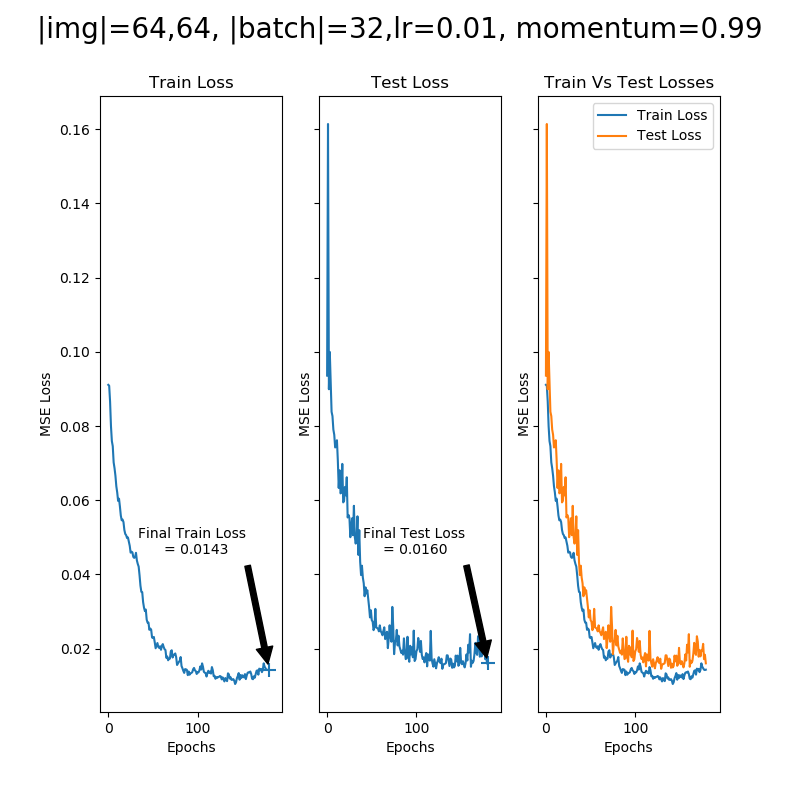

In [4]:
train_loss = [sum(r)/len(r) for r in fit_result.train_loss]
test_loss = [sum(r)/len(r) for r in fit_result.test_loss]

fig, axes = plt.subplots(1,3, figsize=(8,8), sharex=True, sharey=True)

title_args = re.search( r'^special_fusenet,img_size=(\d+,\d+),batch_size=(\d+),betas=(\d+.\d+,\d+.\d+),lr=(\d+.\d+),momentum=(\d+.\d+)', CKPT_BASE_NAME)
if title_args:
    img_size   = title_args.group(1)
    batch_size = title_args.group(2)
    betas      = title_args.group(3)
    lr         = title_args.group(4)
    momentum   = title_args.group(5)
    fig.suptitle(f'|img|={img_size}, |batch|={batch_size},lr={lr}, momentum={momentum}', fontsize=20)
    
axes[0].plot(train_loss, label='Train Loss')
axes[0].set_title('Train Loss')
axes[0].scatter(x=len(train_loss), y=train_loss[-1], marker='+', s=100)
axes[0].annotate("Final Train Loss\n= {0:.4f}    ".format(train_loss[-1]),
                          xy=(len(train_loss), train_loss[-1]), xycoords='data',
                          xytext=(0.8, 0.3), textcoords='axes fraction',
                          arrowprops=dict(facecolor='black', shrink=0.05),
                          horizontalalignment='right', verticalalignment='top')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('MSE Loss')


axes[1].plot(test_loss,  label='Test Loss')
axes[1].set_title('Test Loss')
axes[1].scatter(x=len(test_loss), y=test_loss[-1], marker='+', s=100)
axes[1].annotate("Final Test Loss\n= {0:.4f}    ".format(test_loss[-1]),
                          xy=(len(test_loss), test_loss[-1]), xycoords='data',
                          xytext=(0.8, 0.3), textcoords='axes fraction',
                          arrowprops=dict(facecolor='black', shrink=0.05),
                          horizontalalignment='right', verticalalignment='top')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MSE Loss')


axes[2].plot(train_loss, label='Train Loss')
axes[2].plot(test_loss,  label='Test Loss')
axes[2].set_title('Train Vs Test Losses')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('MSE Loss')

axes[2].legend()

plt.show()

## We shell now review our model's Loss on the Test Set & Validation Set and watch it's output's Visual Quality for diffrent kinds of inference:
* Regular Mode: RGB & Depth
* No Depth: RGB & Zeros instead of Depth
* No RGB: Zeros instead of RGB & Depth
* Noise Depth: RGB & White Gaussian Noise istead of Depth
* Noise RGB: White Gaussian Noise istead of RGB & Depth


In [5]:
fusenetmodel = SpecialFuseNetModel(sgd_lr=LR, sgd_momentum=MOMENTUM, sgd_wd=WEIGHT_DECAY,device=device)
try:
    print(f'[I] - Load State Dict ...', end=' ')
    fusenetmodel.load_state_dict(saved_state['model_state'])
    print('Done.')
except Exception as e:
    print(f'\n[E] - {e}')
try:
    print(f'[I] - Set Model to Evaluation Mode ...', end=' ')
    fusenetmodel.train(False)
    print('Done.')
except Exception as e:
    print(f'\n[E] - {e}')
    
trainer = FuseNetTrainer(model=fusenetmodel, device=device, num_epochs=1)

[I] - device=cpu
    - seed=42
    - dropout_p=0.4
    - optimizer=None
    - scheduler=None

[I] - Init SpecialFuseNet
    - warm start=True
    - BN momentum=0.1
    - dropout_p=0.4

[I] - Check Features Disabled
[I] - Initialize Net.
    - Init type=xavier
    - Init gain=0.02

[I] - default optimizer set: SGD(lr=0.01,momentum=0.99,weight_decay=0.0005)
[I] - default scheduler set: StepSR(step_size=1000,gamma=0.1)
[I] - Load State Dict ... Done.
[I] - Set Model to Evaluation Mode ... Done.
[I (FuseNetTrainer)] - model=<models.SpecialFuseNetModel object at 0x7f804f7d3b50>
                     - num_epochs=1
                     - device=cpu
                      - seed=42



{'both': 'Regular Mode: RGB & Depth ', 'zero_depth': 'No Depth: RGB & Zeros instead of Depth ', 'zero_rgb': 'No RGB: Zeros instead of RGB & Depth ', 'noise_depth': 'Noise Depth: RGB & White Gaussian Noise istead of Depth', 'noise_rgb': 'Noise RGB: White Gaussian Noise istead of RGB & Depth'}
[I] - 0) both

[I (rgbd_gradients_dataloader)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2
                                - batch_size=32
                                - num_workers=4
                                - train_test_ratio=0.8
                                - image_size=(64, 64)
                                - use_transforms=True
                                - overfit_mode=False
                                - seed=42
                                - constant_index=None
                                - inference=both

[I (rgbd_gradients_inference_dataset)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2
                             

<IPython.core.display.Javascript object>


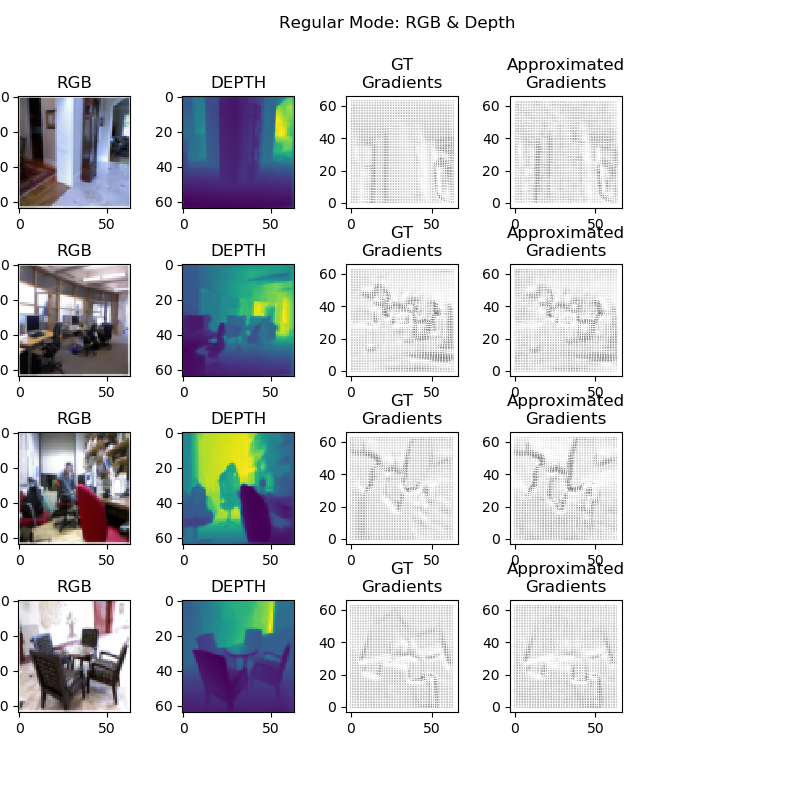

test_batch (Avg. Loss 0.015: 100%|██████████| 8/8 [00:13<00:00,  1.75s/it]
[I] - Test Set Average Loss: 0.015044770203530788
**************************************************************************************************
[I] - 1) zero_depth

[I (rgbd_gradients_dataloader)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2
                                - batch_size=32
                                - num_workers=4
                                - train_test_ratio=0.8
                                - image_size=(64, 64)
                                - use_transforms=True
                                - overfit_mode=False
                                - seed=42
                                - constant_index=None
                                - inference=zero_depth

[I (rgbd_gradients_inference_dataset)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2
                                       - image_size=(64, 64)
                         

<IPython.core.display.Javascript object>


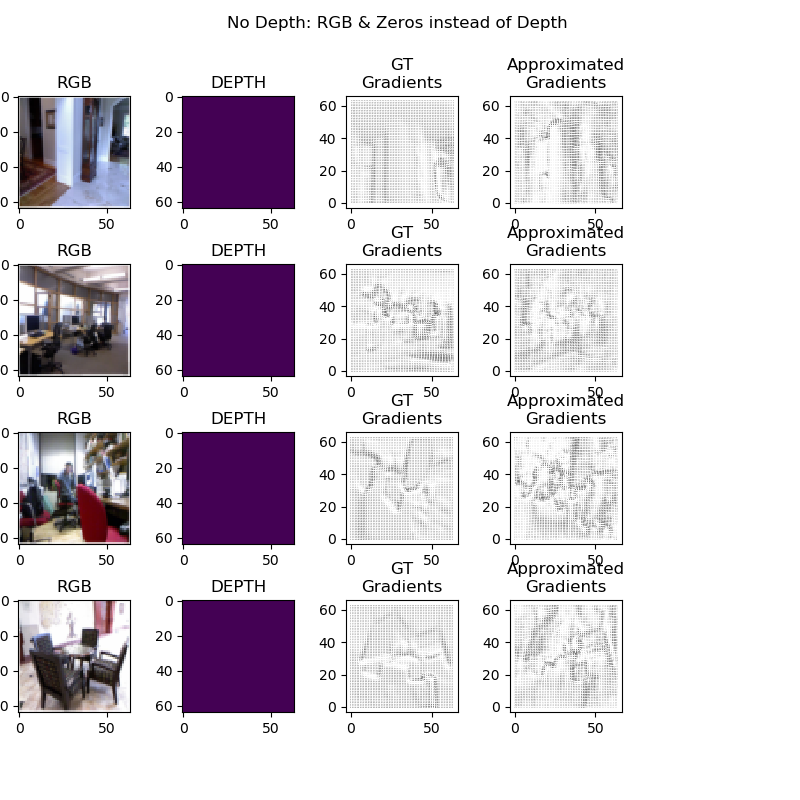

test_batch (Avg. Loss 0.123: 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]
[I] - Test Set Average Loss: 0.12288195081055164
**************************************************************************************************
[I] - 2) zero_rgb

[I (rgbd_gradients_dataloader)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2
                                - batch_size=32
                                - num_workers=4
                                - train_test_ratio=0.8
                                - image_size=(64, 64)
                                - use_transforms=True
                                - overfit_mode=False
                                - seed=42
                                - constant_index=None
                                - inference=zero_rgb

[I (rgbd_gradients_inference_dataset)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2
                                       - image_size=(64, 64)
                              

<IPython.core.display.Javascript object>


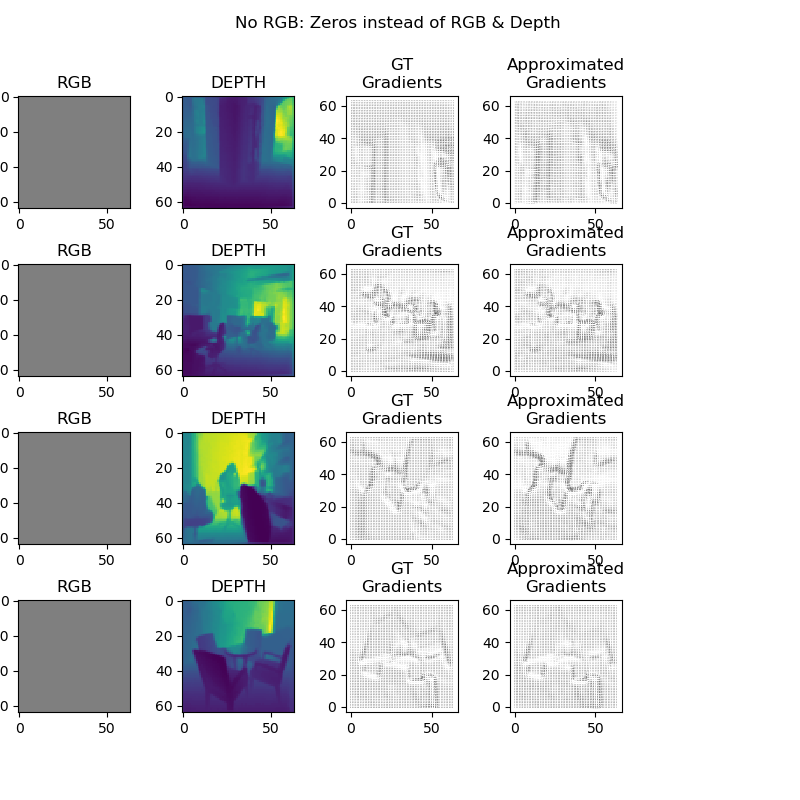

test_batch (Avg. Loss 0.014: 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]
[I] - Test Set Average Loss: 0.014238233678042889
**************************************************************************************************
[I] - 3) noise_depth

[I (rgbd_gradients_dataloader)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2
                                - batch_size=32
                                - num_workers=4
                                - train_test_ratio=0.8
                                - image_size=(64, 64)
                                - use_transforms=True
                                - overfit_mode=False
                                - seed=42
                                - constant_index=None
                                - inference=noise_depth

[I (rgbd_gradients_inference_dataset)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2
                                       - image_size=(64, 64)
                       

<IPython.core.display.Javascript object>


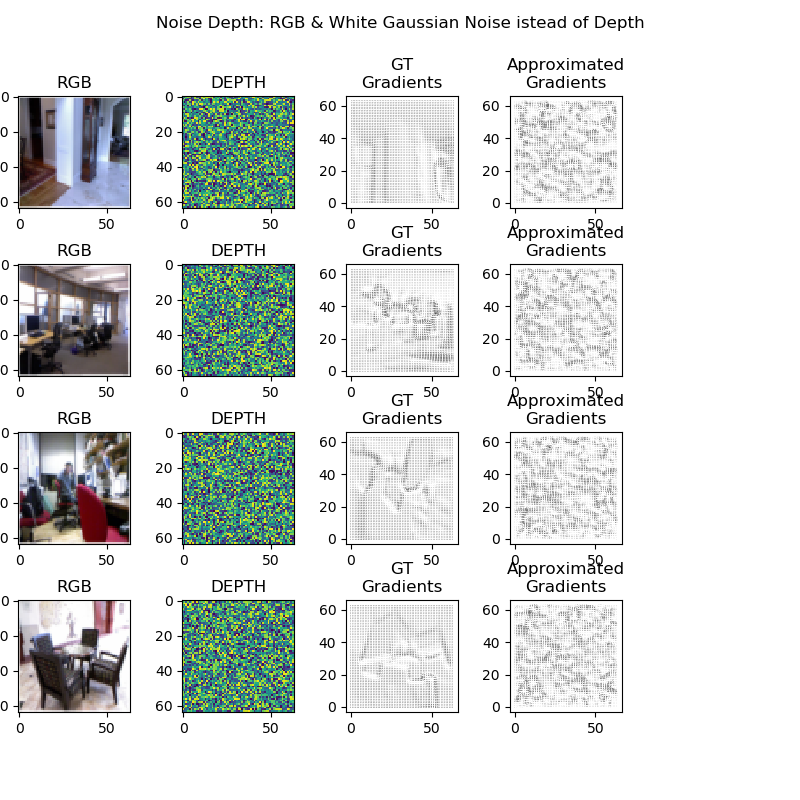

test_batch (Avg. Loss 0.204: 100%|██████████| 8/8 [00:13<00:00,  1.67s/it]
[I] - Test Set Average Loss: 0.20373851992189884
**************************************************************************************************
[I] - 4) noise_rgb

[I (rgbd_gradients_dataloader)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2
                                - batch_size=32
                                - num_workers=4
                                - train_test_ratio=0.8
                                - image_size=(64, 64)
                                - use_transforms=True
                                - overfit_mode=False
                                - seed=42
                                - constant_index=None
                                - inference=noise_rgb

[I (rgbd_gradients_inference_dataset)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2
                                       - image_size=(64, 64)
                            

<IPython.core.display.Javascript object>


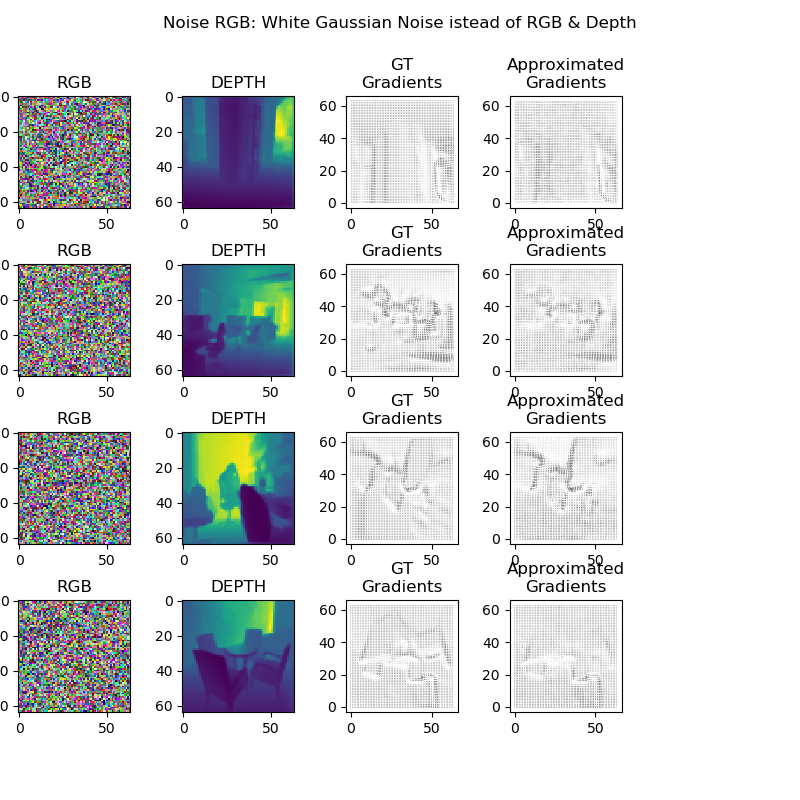

test_batch (Avg. Loss 0.016: 100%|██████████| 8/8 [00:11<00:00,  1.48s/it]
[I] - Test Set Average Loss: 0.015699603711254895
**************************************************************************************************


In [6]:
experiments  = ['both', 'zero_depth', 'zero_rgb', 'noise_depth', 'noise_rgb']

experiments_dict = {
    'both'        : 'Regular Mode: RGB & Depth ',
    'zero_depth'  : 'No Depth: RGB & Zeros instead of Depth ',
    'zero_rgb'    : 'No RGB: Zeros instead of RGB & Depth ',
    'noise_depth' : "Noise Depth: RGB & White Gaussian Noise istead of Depth",
    'noise_rgb'   : "Noise RGB: White Gaussian Noise istead of RGB & Depth",
}

eval_losses = {
    'both'        : 0,
    'zero_depth'  : 0,
    'zero_rgb'    : 0,
    'noise_depth' : 0,
    'noise_rgb'   : 0
}

print(experiments_dict)
for i,exp in enumerate(experiments):
    print(f'[I] - {i}) {exp}\n')
    
    _,dl_test = rgbd_gradients_dataloader(DATASET_DIR, BATCH_SIZE, NUM_WORKERS, TRAIN_TEST_RATIO,
                                          IMAGE_SIZE, None, use_transforms=True,
                                          inference=exp)
    
    sample = next(iter(dl_test))
    rgb        = sample['rgb']
    depth      = sample['depth']
    x_gt       = sample['x']
    y_gt       = sample['y']
    assert rgb.shape[0] == depth.shape[0] == x_gt.shape[0] == y_gt.shape[0]
    
#     print(torch.max(rgb), torch.min(rgb), torch.mean(rgb), torch.std(rgb))
#     print(torch.max(depth), torch.min(depth), torch.mean(depth), torch.std(depth))
    
    with torch.no_grad():
        xy = fusenetmodel(rgb,depth)
    x = xy[:,0,:,:].unsqueeze(1)
    y = xy[:,1,:,:].unsqueeze(1)
    try:
        assert x.shape == x_gt.shape and y.shape == y_gt.shape
    except:
        print(f"x.shape={x.shape} != x_gt.shape={x_gt.shape} or y.shape={y.shape} != y_gt.shape={y_gt.shape}")
    
    batch_dim  = rgb.shape[0]
    rows       = min(batch_dim,4)
    fig, axes  = plt.subplots(nrows=rows, ncols=4, figsize=(8,8), subplot_kw={'aspect': 1},
                             gridspec_kw=dict(hspace=0.5, wspace=0.1, left=0, right=0.8))
    fig.suptitle(experiments_dict[exp])
    for i in range(rows):
        rgb_i        = rgb[i,:,:,:]
        depth_i      = depth[i,:,:,:]
        x_gt_i       = x_gt[i,:,:,:].squeeze(0)
        y_gt_i       = y_gt[i,:,:,:].squeeze(0)
        x_i          = x[i,:,:,:].squeeze(0)
        y_i          = y[i,:,:,:].squeeze(0)
        rgb_i        = torch2np_u8(rgb_i)
        depth_i      = torch2np_u8(depth_i)
        
        axes[i,0].imshow(rgb_i)
        axes[i,0].set_title('RGB')
        axes[i,1].imshow(depth_i)
        axes[i,1].set_title('DEPTH')
        
        X_gt,Y_gt = np.meshgrid(np.arange(x_gt_i.shape[1]), np.arange(x_gt_i.shape[0]))
        axes[i,2].quiver(X_gt, Y_gt, x_gt_i, y_gt_i, pivot='tip', units='xy')
        axes[i,2].set_title('GT\nGradients')
        
        X,Y = np.meshgrid(np.arange(x_i.shape[1]), np.arange(x_i.shape[0]))
        axes[i,3].quiver(X, Y, x_i, y_i, pivot='tip', units='xy')
        axes[i,3].set_title('Approximated\nGradients')
           
    fig.show()
    
    eval_result = trainer.eval(dl_test)
    print(f'[I] - Test Set Average Loss: {sum(eval_result.losses)/len(eval_result.losses)}')
    eval_losses[exp] = sum(eval_result.losses)/len(eval_result.losses)
    
    print('*'*98)

## Let's plot each experiment Evaluation Loss to compare:

<IPython.core.display.Javascript object>


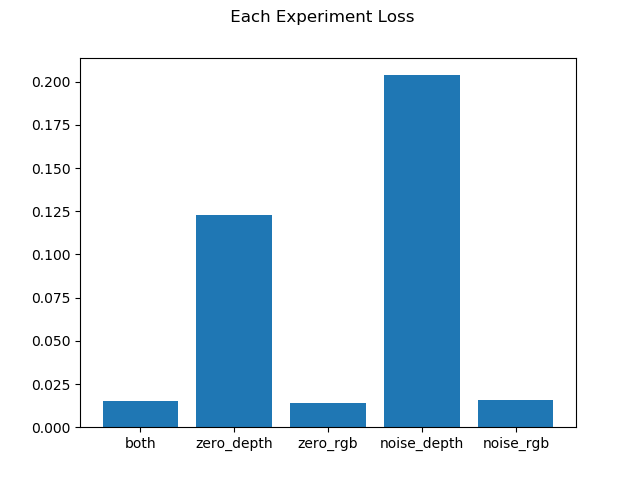

In [7]:
eval_losses
fig, ax = plt.subplots()
fig.suptitle(' Each Experiment Loss')
x = np.arange(len(eval_losses))
ax.bar(x, height=list(eval_losses.values()))
plt.xticks(x, list(eval_losses.keys()))
fig.show()

### As we can see from the bar plot above, the Network has learnt to approximate the Depth Image Gradients, as originally calculated using Classic methods (Convolution with a Sobel kernel).
* Minimal loss achieved with the RGB image zeroed, but it is almost equal to the loss with both the RGB & Depth images and to the loss with the RGB image drawed from a Uniform Distribution. 
* We deduce therefore that the Network has learnt to **ignore** the RGB image, as the loss over the Testset is the smallest when the RGB image zeroed, but almost equal to the case with both the RGB image and the Depth image